In [1]:
import warnings
warnings.filterwarnings(action='ignore') #경고 메시지 무시

In [2]:
import numpy as np
import folium
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import point
from sklearn.cluster import KMeans
import fiona
import pyproj  # 좌표계 정의/변환용 라이브러리
from fiona.crs import from_epsg
import seaborn as sns

# 1. 데이터 확인

### 1) 인구데이터 확인

- 인구정보 확인
    - 법정동으로 구분하기 위해 데이터 id 생성 -> QGIS로 법정경계(읍면동)와 결합하여 '동' 생성
    - 인구정보(고령, 유소년)+법정경계(읍면동)으로 결합한 데이터로 불러오기

In [3]:
old = gpd.read_file('17-1.수원시_인구정보(고령)_행정동.geojson')
young = gpd.read_file('19-1.수원시_인구정보(유소년)_행정동.geojson')

인구정보에 행정동을 결합.  
고령, 유소년 데이터수가 늘어남. 12500  -> 14404   
결측값도 늘어남. 고령 8001 -> 9060  / 유소년 8652 -> 9855

In [4]:
# 결측값 확인
old.isnull().sum(axis=0)  # 9060
young.isnull().sum(axis=0)  # 9855

id              0
gid             0
val          9855
ADM_DR_CD       0
ADM_DR_NM       0
geometry        0
dtype: int64

In [5]:
# 결측행 제거
df_old = old.dropna(axis=0)  # 5344
df_young = young.dropna(axis=0)  # 4549

In [6]:
# 중복행 제거
df_old = df_old.drop_duplicates(subset=['id'], keep='first', ignore_index=True)  # 중복제거 = 4496
len(df_old)

df_young = df_young.drop_duplicates(subset=['id'], keep='first', ignore_index=True)  # 중복제거 = 3845
len(df_young)

3845

In [7]:
"""
--------------------- 수정1 : 거주인구 young+old
"""
# 유소년+노령 거주인구수를 거주인구로 병합
pop = pd.concat([df_old,df_young], ignore_index=True)
pop.head()

,id,gid,val,ADM_DR_CD,ADM_DR_NM,geometry
0,110다사496197,다사496197,0.0,3101265,금곡동,"MULTIPOLYGON (((126.93151 37.27485, 126.93150 ..."
1,146다사497196,다사497196,36.0,3101265,금곡동,"MULTIPOLYGON (((126.93264 37.27396, 126.93263 ..."
2,147다사497197,다사497197,169.0,3101265,금곡동,"MULTIPOLYGON (((126.93263 37.27486, 126.93263 ..."
3,148다사497198,다사497198,40.0,3101265,금곡동,"MULTIPOLYGON (((126.93263 37.27576, 126.93262 ..."
4,154다사497204,다사497204,0.0,3101262,입북동,"MULTIPOLYGON (((126.93259 37.28117, 126.93258 ..."


In [8]:
# 인구정보 데이터 위도, 경도 추출
pop['point'] = pop['geometry'].centroid
pop['lon'] = pop['point'].map(lambda p: p.x)
pop['lat'] = pop['point'].map(lambda p: p.y)

In [9]:
# start node
pop = pop[pop.val>0]

In [10]:
# 망포1동, 망포2동을 망포1,2동으로 합침
pop['ADM_DR_NM'] =pop.apply(lambda x: '망포1.2동' if (x.ADM_DR_NM=='망포1동')|(x.ADM_DR_NM=='망포2동') else x.ADM_DR_NM,axis=1)
pop.head()

,id,gid,val,ADM_DR_CD,ADM_DR_NM,geometry,point,lon,lat
1,146다사497196,다사497196,36.0,3101265,금곡동,"MULTIPOLYGON (((126.93264 37.27396, 126.93263 ...",POINT (126.93320 37.27441),126.933200,37.274412
2,147다사497197,다사497197,169.0,3101265,금곡동,"MULTIPOLYGON (((126.93263 37.27486, 126.93263 ...",POINT (126.93319 37.27531),126.933194,37.275313
3,148다사497198,다사497198,40.0,3101265,금곡동,"MULTIPOLYGON (((126.93263 37.27576, 126.93262 ...",POINT (126.93319 37.27621),126.933187,37.276215
7,189다사498195,다사498195,24.0,3101265,금곡동,"MULTIPOLYGON (((126.93377 37.27306, 126.93377 ...",POINT (126.93434 37.27352),126.934335,37.273516
8,190다사498196,다사498196,62.0,3101265,금곡동,"MULTIPOLYGON (((126.93377 37.27396, 126.93376 ...",POINT (126.93433 37.27442),126.934328,37.274417


- 유동인구 확인

In [11]:
# 유동인구 데이터 확인(10대, 60대만 추출)
f_pop = pd.read_csv('15.수원시_성연령별_유동인구(2020).csv')
# float_pop = f_pop.iloc[:,[0,1,6,7,12,13,14]]
f_pop_select = f_pop[['STD_YM','MAN_FLOW_POP_CNT_10G','MAN_FLOW_POP_CNT_60GU','WMAN_FLOW_POP_CNT_10G','WMAN_FLOW_POP_CNT_60GU',
                     'lon','lat']]

# 유동인구 위치 및 유동인구비율(10대, 60대) 전체 sum
f_pop_select['val'] = f_pop_select.iloc[:,1:4].sum(axis=1)
f_pop_total = f_pop_select[['STD_YM','val','lat','lon']]


f_pop_total.isnull().sum(axis=0)  # 결측치 확인 => 0
f_pop_total = f_pop_total.reset_index()
# f_pop_total.to_csv('float_pop.csv')
len(f_pop_total)  # 416409

416409

- 법정동으로 구분하기 위해 데이터 id 생성 -> QGIS로 법정경계(읍면동)와 결합하여 '동' 생성
- 유동인구(10대, 60대)+법정경계(읍면동)으로 결합한 데이터로 불러오기

In [12]:
float_pop = gpd.read_file('유동인구_고령_유소년.geojson')
float_pop.isnull().sum(axis=0)  # 0
df_float_pop = float_pop[['STD_YM','val','lat','lon','ADM_DR_NM']]
len(df_float_pop)

416409

In [13]:
df_float_pop['ADM_DR_NM'] =df_float_pop.apply(lambda x: '망포1.2동' if (x.ADM_DR_NM=='망포1동')|(x.ADM_DR_NM=='망포2동') else x.ADM_DR_NM,axis=1)

In [14]:
df_float_pop_sum = df_float_pop.groupby(df_float_pop['ADM_DR_NM']).sum()
df_float_pop_sum=df_float_pop_sum.reset_index()
df_float_pop_sum.columns = ['동','STD_YM','val','lat','lon']
df_float_pop_sum = df_float_pop_sum[['동','val','lat','lon']]

In [15]:
# 지역 면적당 유동인구 비율동인구 비율
# area_suwon = pd.read_csv('area_suwon.csv', encoding='CP949')
# area_join = pd.merge(area_suwon, df_float_pop_sum, on='동')
# area_join['면적당유동인구'] = area_join['val']/area_join['총면적']
# round(area_join['면적당유동인구']/sum(area_join['면적당유동인구'])*30)

In [16]:
# df_float_pop_sum = df_float_pop.groupby(df_float_pop['ADM_DR_NM']).sum()

### 2) 위치 데이터 확인

In [17]:
# 버스정류장 위치 확인
busstop = pd.read_csv('1.수원시_버스정류장.csv')
busstop.drop(busstop[busstop['BIS설치여부']!=1].index, inplace=True)  # BIS 미설치 제외
# busstop.to_csv('bus_BIS.csv') # BIS 미설치 버스정류장 데이터 저장
busstop.head()

,정류장ID,정류장명,정류장유형,환승역타입,위치(동),쉘터,BIS설치여부,LED,LCD,LED+LCD복합형,알뜰형,임대형(음성),lon,lat
0,201000313,권선구청,"시내,마을",일반,경기도 수원시 서둔동,1.0,1.0,1.0,NaN,NaN,NaN,NaN,126.970983,37.256983
2,201000345,남수원초등학교,시내,일반,경기도 수원시 세류2동,NaN,1.0,NaN,NaN,NaN,1.0,NaN,127.016000,37.251091
3,201000379,신미주아파트,시내,일반,경기도 수원시 금곡동,NaN,1.0,1.0,NaN,NaN,NaN,NaN,126.953845,37.268806
4,201000055,농수산물시장,시내,일반,경기도 수원시 권선1동,NaN,1.0,NaN,1.0,NaN,NaN,NaN,127.029815,37.256755
5,201000268,곡반중학교,시내,일반,경기도 수원시 곡선동,1.0,1.0,1.0,NaN,NaN,NaN,NaN,127.034254,37.246081


In [18]:
# 버스정류소 위치(동)만 추출
busstop['dong'] = busstop['위치(동)'].str.split(" ").str[2]

In [19]:
# 태장동 -> 망포1,2동으로 변경
busstop['dong'] =busstop.apply(lambda x: '망포1.2동' if (x.dong=='태장동') else x.dong,axis=1)

In [20]:
# 버스정류소 사용할 변수 추출
bus = busstop[['정류장ID','정류장명','dong','lat','lon']]
bus.head()

,정류장ID,정류장명,dong,lat,lon
0,201000313,권선구청,서둔동,37.256983,126.970983
2,201000345,남수원초등학교,세류2동,37.251091,127.016000
3,201000379,신미주아파트,금곡동,37.268806,126.953845
4,201000055,농수산물시장,권선1동,37.256755,127.029815
5,201000268,곡반중학교,곡선동,37.246081,127.034254


In [21]:
# 수원시_법정경계(시군구) 데이터
area = gpd.read_file("29.수원시_법정경계(시군구).geojson") 
area.head()

,SIG_CD,SIG_KOR_NM,geometry
0,41111,수원시 장안구,"MULTIPOLYGON (((127.01976 37.35104, 127.02008 ..."
1,41113,수원시 권선구,"MULTIPOLYGON (((127.03723 37.23684, 127.03679 ..."
2,41115,수원시 팔달구,"MULTIPOLYGON (((127.03582 37.29361, 127.03644 ..."
3,41117,수원시 영통구,"MULTIPOLYGON (((127.07484 37.26588, 127.07488 ..."


In [22]:
# 행정경계(동별) 데이터 확인
dong=gpd.read_file('31.수원시_행정경계(읍면동).geojson')
dong.head()

,ADM_DR_CD,ADM_DR_NM,geometry
0,3101154,파장동,"MULTIPOLYGON (((127.00491 37.33910, 127.00535 ..."
1,3101155,율천동,"MULTIPOLYGON (((126.97444 37.30857, 126.97466 ..."
2,3101156,정자1동,"MULTIPOLYGON (((126.98764 37.31051, 126.98754 ..."
3,3101157,정자2동,"MULTIPOLYGON (((126.99806 37.29766, 126.99830 ..."
4,3101159,송죽동,"MULTIPOLYGON (((127.01135 37.31892, 127.01146 ..."


In [23]:
"""
# 유소년, 고령인구 관련 시설
Qgis로 행정경계(읍면동)과 결합하여 동을 추출하여 병합함
"""

# 학교(어린이집, 유치원, 초/중/고등학교)
school = gpd.read_file('school.geojson')
df_school = school[['시설구분명','시설명','ADM_DR_NM','WGS84위도','WGS84경도']]
df_school.columns = ['class','node_name','dong','lat','lon']
df_school.head()

# 복지관, 경로당, 요양원 등 고령인구 관련 시설
senior_center = gpd.read_file('senior_center.geojson')
df_senior_center = senior_center[['시설종류','시설명','ADM_DR_NM','lat','lon']]
df_senior_center.columns = ['class','node_name','dong','lat','lon']
df_senior_center.head()

,class,node_name,dong,lat,lon
0,경로당,곡반정경로당,곡선동,37.234046,127.025077
1,경로당,망포쌍용2차(아),망포1동,37.234304,127.051941
2,경로당,꿈에그린(아) 경로당,평동,37.235194,126.974598
3,경로당,권선삼성(아)경로당,곡선동,37.235740,127.029306
4,경로당,한솔(아)경로당,곡선동,37.236039,127.027545


In [24]:
# 학교, 고령인구 시설 데이터 합침# 학교, 고령인구 시설 데이터 합침
center = pd.concat([df_school,df_senior_center], ignore_index=True)
len(center)  # 2222

2222

In [25]:
# 시설 내 위도, 경도 겹치는 행 삭제
df_center = center.drop_duplicates(subset=['lat','lon'],keep='first', ignore_index=True)
len(df_center)  # 1965

1965

In [26]:
# 망포1동 망포2동을 망포1,2동으로 변경
df_center['dong'] =df_center.apply(lambda x: '망포1.2동' if (x.dong=='망포1동')|(x.dong=='망포2동') else x.dong,axis=1)

In [27]:
# center 위치 확인
center = [37.26404308610561, 127.02347288584993]
m = folium.Map(location=center, zoom_start=12,tiles='cartodbpositron')
style1 = {'fillColor': False, 'color': '#475974'}
style2 = {'fillColor': '#e3fc03', 'color': '#81f0b7'}

folium.GeoJson(data=area["geometry"], style_function=lambda x:style1).add_to(m) #수원시 구별 경계
for i in range(len(df_center)):
    folium.CircleMarker(
        location=[df_center.iloc[i]['lat'], df_center.iloc[i]['lon']],
        color='purple',
        fill=True,
        fill_color = 'purple',
        radius=10
).add_to(m)
    
# m

# 2. 데이터 분석

## 1) all feature kmeans

In [28]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [29]:
"""
동별 count, sum 계산
"""

# 동별 시설 count
df_center2 = df_center[['class','dong']]
df_center2_cnt = df_center2.groupby(by=['dong'], as_index=False).count()
df_center2_cnt.columns = ['dong','center_count']

# 거주인구수(동별 합계)
df_pop = pop[['ADM_DR_NM','val']]
df_pop.columns = ['dong', 'val']
df_pop_Sum = df_pop.groupby(by=['dong'], as_index=False).sum()
df_pop_Sum.columns = ['dong','pop_sum']

# 유동인구수(동별 합계)
df_float_pop2 = df_float_pop[['ADM_DR_NM','val']]
df_float_pop2.columns = ['dong', 'val']
df_float_Sum = df_float_pop2.groupby(by=['dong'], as_index=False).sum()
df_float_Sum.columns = ['dong','float_sum']

In [30]:
total1 = pd.merge(bus, df_center2_cnt, how="left", on='dong')
total2 = pd.merge(total1,df_pop_Sum, how="left", on='dong')
total3 = pd.merge(total2,df_float_Sum, how="left", on='dong')

total = total3[['center_count','pop_sum','float_sum']]

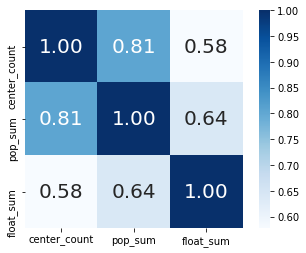

In [31]:
corr = total.corr(method='pearson')
df_heatmap = sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 20}, fmt = '.2f', square = True, cmap = 'Blues')

In [32]:
# 표준화
sd = StandardScaler()
total_sd=pd.DataFrame(sd.fit_transform(total))

In [33]:
total_sd.index = np.array(total3['정류장ID'])

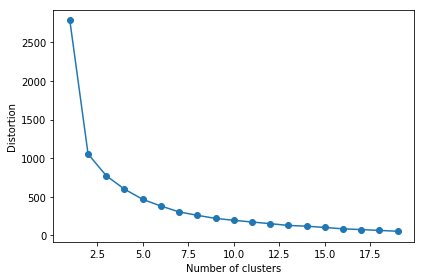

In [34]:
# cluster 최적값
dist =[]
for i in range(1,20):
    k = KMeans(n_clusters=i,
          init='k-means++',
           n_init=10,
           max_iter=300,
           random_state=0)
    k.fit(total_sd)
    dist.append(k.inertia_)

# plt.plot(range(1,20),dist, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
# plt.tight_layout()
# plt.show()

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f76a87137f0>,
                 k=None, model=None)

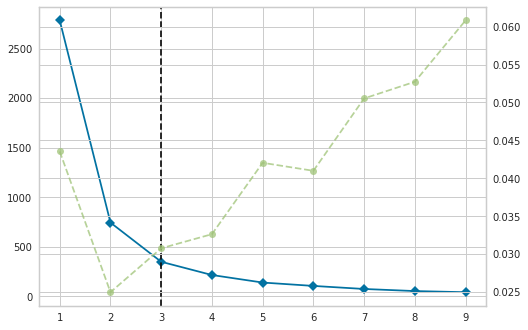

In [35]:
from yellowbrick.cluster import KElbowVisualizer
 
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(total_sd.values.reshape(-1,1))

In [36]:
total_sd_arr = total_sd.values

kmeans = KMeans(n_clusters =3).fit(total_sd_arr)
kmeans.cluster_centers_

array([[ 0.6112237 ,  0.89214257,  1.70678651],
       [-0.84440388, -0.95345897, -0.76931814],
       [ 0.7481715 ,  0.73925951,  0.08078704]])

In [37]:
total_sd['cluster'] = kmeans.labels_
total_sd.reset_index(inplace=True)

In [38]:
total_sd

,index,0,1,2,cluster
0,201000313,0.375216,0.830734,0.554657,2
1,201000345,-1.098195,-0.465356,-0.580193,1
2,201000379,0.755451,1.511596,-0.125983,2
3,201000055,-0.527842,-0.850870,-0.863355,1
4,201000268,-0.290196,-0.777272,0.420009,1
...,...,...,...,...,...
923,202000249,-0.813019,-0.267502,-1.337535,1
924,202000241,0.232628,-0.795433,0.004581,1
925,202000246,0.232628,-0.795433,0.004581,1
926,202000239,0.232628,-0.795433,0.004581,1


In [39]:
total_sd.columns = ['정류장ID','0','1','2','cluster']
cluster = total_sd[['정류장ID','cluster']]

In [41]:
select_bus = pd.merge(total3, cluster, how="left", on='정류장ID')
select_bus

,정류장ID,정류장명,dong,lat,lon,center_count,pop_sum,float_sum,cluster
0,201000313,권선구청,서둔동,37.256983,126.970983,62,10348.0,360678.78,2
1,201000345,남수원초등학교,세류2동,37.251091,127.016000,31,6280.0,194155.03,1
2,201000379,신미주아파트,금곡동,37.268806,126.953845,70,12485.0,260804.19,2
3,201000055,농수산물시장,권선1동,37.256755,127.029815,43,5070.0,152604.94,1
4,201000268,곡반중학교,곡선동,37.246081,127.034254,48,5301.0,340920.98,1
...,...,...,...,...,...,...,...,...,...
923,202000249,화서오거리,화서1동,37.278865,126.999697,37,6901.0,83025.55,1
924,202000241,숙지공원.화서동굿모닝힐.화서다산도서관,화서2동,37.284316,126.995823,59,5244.0,279962.70,1
925,202000246,엘지아파트.금강아파트,화서2동,37.287994,126.981714,59,5244.0,279962.70,1
926,202000239,꽃뫼신동아아파트,화서2동,37.286663,126.986076,59,5244.0,279962.70,1


In [42]:
select_bus2 = select_bus.groupby(['cluster']).count()
select_bus2.sort_values(by=['정류장ID'], ascending=False)

,정류장ID,정류장명,dong,lat,lon,center_count,pop_sum,float_sum
cluster,,,,,,,,
1,421,421,421,421,421,421,421,421
2,333,333,333,333,333,333,333,333
0,174,174,174,174,174,174,174,174


In [43]:
select_bus3 = select_bus[select_bus['cluster'].isin([1])]

In [44]:
select_bus3

,정류장ID,정류장명,dong,lat,lon,center_count,pop_sum,float_sum,cluster
1,201000345,남수원초등학교,세류2동,37.251091,127.016000,31,6280.0,194155.03,1
3,201000055,농수산물시장,권선1동,37.256755,127.029815,43,5070.0,152604.94,1
4,201000268,곡반중학교,곡선동,37.246081,127.034254,48,5301.0,340920.98,1
7,202000089,화서역,화서2동,37.284140,126.990494,59,5244.0,279962.70,1
12,202000090,화서역,화서2동,37.283895,126.990107,59,5244.0,279962.70,1
...,...,...,...,...,...,...,...,...,...
923,202000249,화서오거리,화서1동,37.278865,126.999697,37,6901.0,83025.55,1
924,202000241,숙지공원.화서동굿모닝힐.화서다산도서관,화서2동,37.284316,126.995823,59,5244.0,279962.70,1
925,202000246,엘지아파트.금강아파트,화서2동,37.287994,126.981714,59,5244.0,279962.70,1
926,202000239,꽃뫼신동아아파트,화서2동,37.286663,126.986076,59,5244.0,279962.70,1


In [45]:
# center 위치 확인
center = [37.26404308610561, 127.02347288584993]
m = folium.Map(location=center, zoom_start=12,tiles='cartodbpositron')
style1 = {'fillColor': False, 'color': '#475974'}
style2 = {'fillColor': '#e3fc03', 'color': '#81f0b7'}

folium.GeoJson(data=area["geometry"], style_function=lambda x:style1).add_to(m) #수원시 구별 경계
for i in range(len(select_bus3)):
    folium.CircleMarker(
        location=[select_bus3.iloc[i]['lat'], select_bus3.iloc[i]['lon']],
        color='purple',
        fill=True,
        fill_color = 'purple',
        radius=10
).add_to(m)
    
m